Binarized MNIST dataset saved to 'binarized_mnist.pt'!


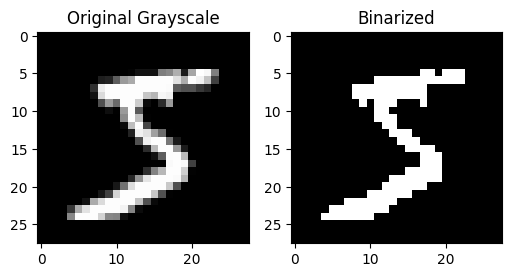

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 二值化函数
def binarize_tensor(tensor, threshold=0.5):
    return (tensor >= threshold).float()

# 1. 预处理MNIST数据集并保存二值化版本
transform = transforms.ToTensor()  # 先转换为[0, 1]
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=64, shuffle=False)

binarized_images = []
labels = []
for x, y in dataloader:
    x_binarized = binarize_tensor(x, threshold=0.5)  # 转换为0或1
    binarized_images.append(x_binarized)
    labels.append(y)

# 拼接为完整数据集
binarized_images = torch.cat(binarized_images, dim=0)  # [60000, 1, 28, 28]
labels = torch.cat(labels, dim=0)  # [60000]
torch.save({'images': binarized_images, 'labels': labels}, 'binarized_mnist.pt')
print("Binarized MNIST dataset saved to 'binarized_mnist.pt'!")

# 可视化验证二值化效果
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mnist.data[0].float() / 255, cmap='gray')  # 原始灰度图
plt.title('Original Grayscale')
plt.subplot(1, 2, 2)
plt.imshow(binarized_images[0].squeeze(), cmap='gray')  # 二值化图
plt.title('Binarized')
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 增强的VAE模型
class VAE(nn.Module):
    def __init__(self, latent_channels=2):
        super(VAE, self).__init__()
        self.latent_channels = latent_channels
        # 编码器：增加一层
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 28x28x1 -> 14x14x32
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),  # 14x14x16 -> 7x7x16
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),  # 7x7x8
            nn.ReLU()
        )
        self.fc_mu = nn.Conv2d(8, latent_channels, kernel_size=1)  # 7x7x8 -> 7x7x4
        self.fc_logvar = nn.Conv2d(8, latent_channels, kernel_size=1)
        # 解码器：增加一层
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7x4 -> 14x14x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14x8 -> 28x28x8
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=3, padding=1),  # 28x28x1
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# 损失函数（降低beta）
def vae_loss(recon_x, x, mu, logvar, beta=0.2):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div

# 二值化函数
def binarize_tensor(tensor, threshold=0.5):
    return (tensor >= threshold).float()

# 加载二值化数据集
binarized_data = torch.load('binarized_mnist.pt')
binarized_dataset = TensorDataset(binarized_data['images'], binarized_data['labels'])
dataloader = DataLoader(binarized_dataset, batch_size=64, shuffle=True)

# 训练VAE
# vae = VAE(latent_channels=2).cuda()
# optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)  # 提高学习率

# for epoch in range(100):  # 增加epoch
#     for batch_idx, (x, _) in enumerate(dataloader):
#         x = x.cuda()
#         optimizer.zero_grad()
#         recon_x, mu, logvar = vae(x)
#         loss = vae_loss(recon_x, x, mu, logvar)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 100 == 0:
#             print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item():.4f}')

# # 保存模型
# torch.save(vae.state_dict(), 'vae_model_binarized_optimized.pth')
# print("Optimized VAE trained and saved!")

# 从潜在分布采样并可视化


/tmp/ipykernel_3219/2397314659.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  binarized_data = torch.load('binarized_mnist.pt')


In [2]:
vae.eval()
with torch.no_grad():
    # 从N(0, I)采样
    z = torch.randn(1, 2, 7, 7, device='cuda')  # [1, 4, 7, 7]
    x_generated = vae.decode(z)
    x_generated_binarized = binarize_tensor(x_generated, threshold=0.5)
    
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(x_generated[0].cpu().squeeze(), cmap='gray')
    plt.title('Generated (Continuous)')
    plt.subplot(1, 2, 2)
    plt.imshow(x_generated_binarized[0].cpu().squeeze(), cmap='gray')
    plt.title('Generated (Binarized)')
    plt.show()

# 可视化重构效果（可选）
with torch.no_grad():
    x, _ = next(iter(dataloader))
    x = x.cuda()
    recon_x, _, _ = vae(x)
    recon_x_binarized = binarize_tensor(recon_x, threshold=0.5)
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(x[0].cpu().squeeze(), cmap='gray')
    plt.title('Binarized Original')
    plt.subplot(1, 2, 2)
    plt.imshow(recon_x_binarized[0].cpu().squeeze(), cmap='gray')
    plt.title('Reconstructed (Binarized)')
    plt.show()


NameError: name 'vae' is not defined

In [5]:
torch.save(vae.state_dict(), 'vae_model.pth')

NameError: name 'vae' is not defined

In [6]:
vae.eval()
latent_dataset = []
with torch.no_grad():
    for x, _ in dataloader:
        x = x.cuda()
        mu, logvar = vae.encode(x)
        z = vae.reparameterize(mu, logvar)
        latent_dataset.append(z.cpu())
latent_dataset = torch.cat(latent_dataset, dim=0)  # [60000, 4, 7, 7]
torch.save(latent_dataset, 'latent_mnist_binarized.pt')
print("Latent dataset saved to 'latent_mnist_binarized.pt'!")

NameError: name 'vae' is not defined

tensor([[[[-2.3330,  0.8183, -0.8192, -0.1581,  0.8878,  1.5720,  1.1811],
          [ 1.6224,  0.1962, -1.8809,  0.3756,  1.3178,  0.4381, -1.0111],
          [ 0.3871, -0.7817,  1.0916, -1.7128, -0.4244,  0.3743, -1.2177],
          [-0.6634, -0.2422,  1.4919,  0.5341,  0.3830,  0.1213,  0.4567],
          [ 2.1064,  0.0606, -0.3473,  1.5947, -0.2267,  1.0565,  1.3319],
          [ 1.4706, -0.4026,  1.2634, -0.8800, -1.9819, -0.1042, -0.4942],
          [ 1.1466,  0.8408,  0.8621,  1.0246,  0.2667,  0.0710,  1.0885]],

         [[ 0.9100,  0.5073,  0.3587,  0.7047,  0.6145, -1.0174,  0.5506],
          [-0.3884,  0.3472,  0.3297, -0.2421, -1.5173, -1.2680,  1.5901],
          [-0.1080,  0.9657,  1.3449, -1.9021, -0.3049, -1.3752,  1.0189],
          [-1.1384,  1.1536,  0.4828,  1.1757, -0.5286, -1.0592,  0.6066],
          [-0.3251, -1.0693, -1.1199, -1.2227, -1.8545,  0.0691, -0.4420],
          [ 1.3488, -1.0695, -1.3956, -1.6732, -0.6724,  0.3770,  0.9088],
          [-0.7228, -0.

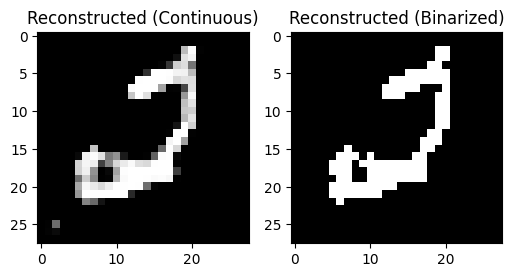

z_0 mean: 0.0571, std: 1.0161, min: -2.3330, max: 2.1064


In [30]:
with torch.no_grad():
    z_0 = latent_dataset[10:11].cuda()  # 取第一个样本，形状 [1, 4, 7, 7]
    print(z_0)
    x_recon = vae.decode(z_0)  # 解码为连续值图像
    x_recon_binarized = binarize_tensor(x_recon, threshold=0.5)  # 二值化
    
    # 可视化
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(x_recon[0].cpu().squeeze(), cmap='gray')
    plt.title('Reconstructed (Continuous)')
    plt.subplot(1, 2, 2)
    plt.imshow(x_recon_binarized[0].cpu().squeeze(), cmap='gray')
    plt.title('Reconstructed (Binarized)')
    plt.show()
    print(f"z_0 mean: {z_0.mean().item():.4f}, std: {z_0.std().item():.4f}, min: {z_0.min().item():.4f}, max: {z_0.max().item():.4f}")

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

class DeepUNet(nn.Module):
    def __init__(self, in_channels=4, T=500):
        super(DeepUNet, self).__init__()
        self.T = T
        
        # 时间嵌入
        self.time_emb = nn.Sequential(
            nn.Embedding(T, 256),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512)
        )
        
        # 下采样
        self.down1 = nn.Conv2d(in_channels, 32, 3, padding=1)  # 4 -> 32
        self.down1_bn = nn.BatchNorm2d(32)
        self.down2 = nn.Conv2d(32, 64, 3, padding=1)  # 32 -> 64
        self.down2_bn = nn.BatchNorm2d(64)
        self.down3 = nn.Conv2d(64, 128, 3, padding=1)  # 64 -> 128
        self.down3_bn = nn.BatchNorm2d(128)
        self.down4 = nn.Conv2d(128, 256, 3, padding=1)  # 128 -> 256
        self.down4_bn = nn.BatchNorm2d(256)
        self.down5 = nn.Conv2d(256, 512, 3, padding=1)  # 256 -> 512
        self.down5_bn = nn.BatchNorm2d(512)
        
        # 瓶颈层
        self.bottleneck = nn.Conv2d(512, 512, 3, padding=1)
        self.bottleneck_bn = nn.BatchNorm2d(512)
        
        # 上采样
        self.up1 = nn.Conv2d(512 + 256, 256, 3, padding=1)  # 512+256 -> 256
        self.up1_bn = nn.BatchNorm2d(256)
        self.up2 = nn.Conv2d(256 + 128, 128, 3, padding=1)  # 256+128 -> 128
        self.up2_bn = nn.BatchNorm2d(128)
        self.up3 = nn.Conv2d(128 + 64, 64, 3, padding=1)  # 128+64 -> 64
        self.up3_bn = nn.BatchNorm2d(64)
        self.up4 = nn.Conv2d(64 + 32, 32, 3, padding=1)  # 64+32 -> 32
        self.up4_bn = nn.BatchNorm2d(32)
        self.up5 = nn.Conv2d(32 + in_channels, 16, 3, padding=1)  # 32+4 -> 16
        self.up5_bn = nn.BatchNorm2d(16)
        
        # 输出层
        self.out = nn.Conv2d(16, in_channels, 1)  # 16 -> 4
    
    def forward(self, x, t):
        # x: [batch, 4, 7, 7], t: [batch]
        t_emb = self.time_emb(t).view(-1, 512, 1, 1).repeat(1, 1, 7, 7)
        
        # 下采样
        d1 = F.relu(self.down1_bn(self.down1(x)))  # [batch, 32, 7, 7]
        d2 = F.relu(self.down2_bn(self.down2(d1)))  # [batch, 64, 7, 7]
        d3 = F.relu(self.down3_bn(self.down3(d2)))  # [batch, 128, 7, 7]
        d4 = F.relu(self.down4_bn(self.down4(d3)))  # [batch, 256, 7, 7]
        d5 = F.relu(self.down5_bn(self.down5(d4)))  # [batch, 512, 7, 7]
        
        # 瓶颈层
        b = F.relu(self.bottleneck_bn(self.bottleneck(d5)) + t_emb)  # [batch, 512, 7, 7]
        
        # 上采样
        u1 = F.relu(self.up1_bn(self.up1(torch.cat([b, d4], dim=1))))  # [batch, 256, 7, 7]
        u2 = F.relu(self.up2_bn(self.up2(torch.cat([u1, d3], dim=1))))  # [batch, 128, 7, 7]
        u3 = F.relu(self.up3_bn(self.up3(torch.cat([u2, d2], dim=1))))  # [batch, 64, 7, 7]
        u4 = F.relu(self.up4_bn(self.up4(torch.cat([u3, d1], dim=1))))  # [batch, 32, 7, 7]
        u5 = F.relu(self.up5_bn(self.up5(torch.cat([u4, x], dim=1))))  # [batch, 16, 7, 7]
        
        return self.out(u5)  # [batch, 4, 7, 7]

# 扩散参数
T = 500
device = 'cuda'
betas = torch.linspace(1e-4, 0.01, T, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

def forward_diffusion(z_0, t):
    noise = torch.randn_like(z_0)
    alpha_t = alphas_cumprod[t].view(-1, 1, 1, 1)
    z_t = torch.sqrt(alpha_t) * z_0 + torch.sqrt(1 - alpha_t) * noise
    return z_t, noise

# 加载数据和模型
latent_dataset = torch.load('latent_mnist_binarized.pt')
batch_size = 64

unet = DeepUNet(in_channels=2, T=T).cuda()
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# for epoch in range(200):
#     for i in range(0, len(latent_dataset), batch_size):
#         z_0 = latent_dataset[i:i+batch_size].cuda()
#         t = torch.randint(0, T, (z_0.size(0),), device='cuda')
#         z_t, noise = forward_diffusion(z_0, t)
        
#         optimizer.zero_grad()
#         pred_noise = unet(z_t, t)
#         loss = F.mse_loss(pred_noise, noise)  # 纯MSE损失
        
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
#         optimizer.step()
        
#         if i % 100 == 0:
#             print(f'Epoch {epoch}, Step {i}, Loss {loss.item():.4f}, LR {scheduler.get_last_lr()[0]:.6f}')
    
#     scheduler.step()

# torch.save(unet.state_dict(), 'deep_unet_model_v6.pth')
# print("Deep U-Net v6 trained and saved!")

/tmp/ipykernel_3219/1813250355.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_dataset = torch.load('latent_mnist_binarized.pt')


In [99]:
unet = DeepUNet(in_channels=2, T=T).cuda()
unet.load_state_dict(torch.load('deep_unet_model_v6.pth'))  # 加载200epoch模型
optimizer = torch.optim.Adam(unet.parameters(), lr=6e-5)  # 重新设置初始学习率
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)  # 每100epoch减半

for epoch in range(200, 400):  # 从200继续到400
    for i in range(0, len(latent_dataset), batch_size):
        z_0 = latent_dataset[i:i+batch_size].cuda()
        t = torch.randint(0, T, (z_0.size(0),), device='cuda')
        z_t, noise = forward_diffusion(z_0, t)
        
        optimizer.zero_grad()
        pred_noise = unet(z_t, t)
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
        optimizer.step()
        
        if i % 100 == 0:
            print(f'Epoch {epoch}, Step {i}, Loss {loss.item():.4f}, LR {scheduler.get_last_lr()[0]:.6f}')
    
    scheduler.step()

torch.save(unet.state_dict(), 'deep_unet_model_v6_extended.pth')
print("U-Net v6 extended training completed and saved!")

/tmp/ipykernel_33380/3654063528.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load('deep_unet_model_v6.pth'))  # 加载200epoch模型


Epoch 200, Step 0, Loss 0.3860, LR 0.000060
Epoch 200, Step 1600, Loss 0.3841, LR 0.000060
Epoch 200, Step 3200, Loss 0.3778, LR 0.000060
Epoch 200, Step 4800, Loss 0.4931, LR 0.000060
Epoch 200, Step 6400, Loss 0.4163, LR 0.000060
Epoch 200, Step 8000, Loss 0.4004, LR 0.000060
Epoch 200, Step 9600, Loss 0.4227, LR 0.000060
Epoch 200, Step 11200, Loss 0.4412, LR 0.000060
Epoch 200, Step 12800, Loss 0.3611, LR 0.000060
Epoch 200, Step 14400, Loss 0.4039, LR 0.000060
Epoch 200, Step 16000, Loss 0.3459, LR 0.000060
Epoch 200, Step 17600, Loss 0.4608, LR 0.000060
Epoch 200, Step 19200, Loss 0.3639, LR 0.000060
Epoch 200, Step 20800, Loss 0.3250, LR 0.000060
Epoch 200, Step 22400, Loss 0.4414, LR 0.000060
Epoch 200, Step 24000, Loss 0.4162, LR 0.000060
Epoch 200, Step 25600, Loss 0.3651, LR 0.000060
Epoch 200, Step 27200, Loss 0.4821, LR 0.000060
Epoch 200, Step 28800, Loss 0.4243, LR 0.000060
Epoch 200, Step 30400, Loss 0.4291, LR 0.000060
Epoch 200, Step 32000, Loss 0.3662, LR 0.000060
Ep

/tmp/ipykernel_3219/1576599642.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load('deep_unet_model_v6.pth'))
/tmp/ipykernel_3219/1576599642

Initial z_t: mean 0.0210, std 1.1029
Step 400: z mean -0.1118, std 0.9576
Step 300: z mean -0.1007, std 0.9826
Step 200: z mean -0.1385, std 1.0455
Step 100: z mean -0.0955, std 1.0981
Final z_0: mean -0.0985, std 1.0935


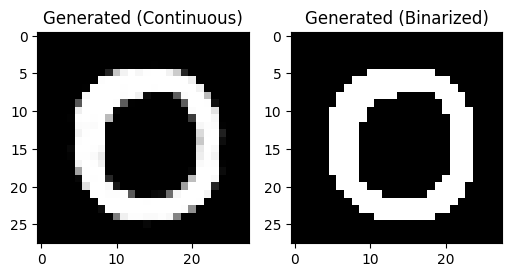

In [9]:
# VAE定义（只用解码器）
# 增强的VAE模型
class VAE(nn.Module):
    def __init__(self, latent_channels=2):
        super(VAE, self).__init__()
        self.latent_channels = latent_channels
        # 编码器：增加一层
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 28x28x1 -> 14x14x32
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),  # 14x14x16 -> 7x7x16
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),  # 7x7x8
            nn.ReLU()
        )
        self.fc_mu = nn.Conv2d(8, latent_channels, kernel_size=1)  # 7x7x8 -> 7x7x4
        self.fc_logvar = nn.Conv2d(8, latent_channels, kernel_size=1)
        # 解码器：增加一层
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7x4 -> 14x14x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14x8 -> 28x28x8
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=3, padding=1),  # 28x28x1
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def reverse_diffusion(z_t, unet, steps=T-1):
    z = z_t
    for step in range(steps, 0, -1):
        t = torch.full((z.size(0),), step-1, device=device)
        pred_noise = unet(z, t)
        alpha_t = alphas_cumprod[step-1].view(1).to(device)
        alpha_t_prev = alphas_cumprod[step-2].view(1).to(device) if step > 1 else torch.tensor(1.0, device=device)
        beta_t = betas[step-1].view(1).to(device)
        z = (z - (1 - alpha_t) / torch.sqrt(1 - alpha_t) * pred_noise) / torch.sqrt(alpha_t_prev)
        if step > 1:
            z = z + torch.sqrt(beta_t) * torch.randn_like(z)
        if step % 100 == 0:
            print(f"Step {step}: z mean {z.mean().item():.4f}, std {z.std().item():.4f}")
    return z

def binarize_tensor(tensor, threshold=0.5):
    return (tensor >= threshold).float()

unet = DeepUNet(in_channels=2, T=T).cuda()
vae = VAE(latent_channels=2).cuda()
unet.load_state_dict(torch.load('deep_unet_model_v6.pth'))
vae.load_state_dict(torch.load('vae_model_binarized_optimized.pth'))
unet.eval()
vae.eval()

with torch.no_grad():
    z_t = torch.randn(1, 2, 7, 7, device='cuda')
    print(f"Initial z_t: mean {z_t.mean().item():.4f}, std {z_t.std().item():.4f}")
    z_0 = reverse_diffusion(z_t, unet)
    print(f"Final z_0: mean {z_0.mean().item():.4f}, std {z_0.std().item():.4f}")
    x_generated = vae.decode(z_0)
    x_generated_binarized = binarize_tensor(x_generated, threshold=0.5)
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(x_generated[0].cpu().squeeze(), cmap='gray')
    plt.title('Generated (Continuous)')
    plt.subplot(1, 2, 2)
    plt.imshow(x_generated_binarized[0].cpu().squeeze(), cmap='gray')
    plt.title('Generated (Binarized)')
    plt.show()

Initial z_t: mean -0.0018, std 1.0002
Step 400: z mean -0.1480, std 0.9865
Step 300: z mean -0.1362, std 1.0173
Step 200: z mean -0.1453, std 1.0568
Step 100: z mean -0.1154, std 1.1031
Final z_0: mean -0.1089, std 1.1107


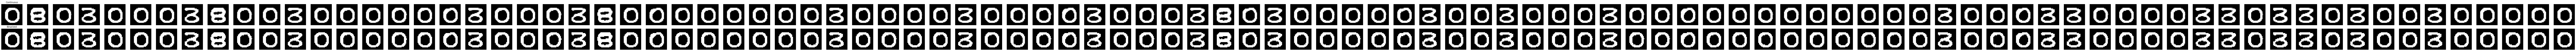

In [10]:
num_images = 100
with torch.no_grad():
    z_t = torch.randn(num_images, 2, 7, 7, device='cuda')  # [10, 4, 7, 7]
    print(f"Initial z_t: mean {z_t.mean().item():.4f}, std {z_t.std().item():.4f}")
    z_0 = reverse_diffusion(z_t, unet)
    print(f"Final z_0: mean {z_0.mean().item():.4f}, std {z_0.std().item():.4f}")
    x_generated = vae.decode(z_0)  # [10, 1, 28, 28]
    x_generated_binarized = binarize_tensor(x_generated, threshold=0.5)

    # 可视化多张图像
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        # 第一行：连续值图像
        axes[0, i].imshow(x_generated[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Continuous')
        
        # 第二行：二值化图像
        axes[1, i].imshow(x_generated_binarized[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Binarized')
    
    plt.tight_layout()
    plt.show()

In [47]:
def noise(z_0, t):
    noise = torch.randn_like(z_0)
    alpha_t = alphas_cumprod[t].view(-1, 1, 1, 1)
    z_t = torch.sqrt(alpha_t) * z_0 + torch.sqrt(1 - alpha_t) * noise
    return z_t, noise

# 原始反向扩散
def reverse_diffusion(z_t, unet, steps=T-1):
    z = z_t
    for step in range(steps, 0, -1):
        t = torch.full((z.size(0),), step-1, device=device)
        pred_noise = unet(z, t)
        alpha_t = alphas_cumprod[step-1].view(1).to(device)
        alpha_t_prev = alphas_cumprod[step-2].view(1).to(device) if step > 1 else torch.tensor(1.0, device=device)
        beta_t = betas[step-1].view(1).to(device)
        z = (z - (1 - alpha_t) / torch.sqrt(1 - alpha_t) * pred_noise) / torch.sqrt(alpha_t_prev)
        if step > 1:
            z = z + torch.sqrt(beta_t) * torch.randn_like(z)
        if step % 100 == 0:
            print(f"Step {step} (No Mask): z mean {z.mean().item():.4f}, std {z.std().item():.4f}")
    return z

# 新的latent inpaint方法（修正版）
def latent_inpaint(z_0, unet, steps=T-1):
    batch_size, channels, height, width = z_0.shape
    
    # 硬编码3x3x2 mask区域 (中心位置)
    center_h = height // 2
    center_w = width // 2
    mask_region = torch.zeros_like(z_0)
    for b in range(batch_size):
        mask_region[b, :2, center_h-1:center_h+2, center_w-1:center_w+2] = 1.0  # 3x3x2区域
        # mask_region[b, :2, center_h-0:center_h+0, center_w-0:center_w+0] = 1.0 
    # 初始化z_init = z_0
    # mask_region[:, :, center_h-0:center_h+0, center_w-0:center_w+0] = 0.0
    z_init = z_0.clone()
    
    # 从z_0加噪到z_k (初始时间步k)
    z_k, _ = noise(z_0, torch.full((batch_size,), steps-1, device=device))
    
    # 反向扩散
    z = z_k
    for t in range(steps, 0, -1):
        t_tensor = torch.full((batch_size,), t-1, device=device)
        
        # z_fg ~ denoise(z_t, d, t)
        pred_noise_fg = unet(z, t_tensor)
        alpha_t_fg = alphas_cumprod[t-1].view(1).to(device)
        alpha_t_prev_fg = alphas_cumprod[t-2].view(1).to(device) if t > 1 else torch.tensor(1.0, device=device)
        z_fg = (z - (1 - alpha_t_fg) / torch.sqrt(1 - alpha_t_fg) * pred_noise_fg) / torch.sqrt(alpha_t_prev_fg)
        
        # z_bg ~ noise(z_init, t)
        z_bg, _ = noise(z_init, t_tensor)
        
        # 融合
        z = z_fg * mask_region + z_bg * (1 - mask_region)
        
        if t > 1:
            z = z + torch.sqrt(betas[t-1].view(1).to(device)) * torch.randn_like(z)
        if t % 100 == 0:
            print(f"Step {t} (With Mask): z mean {z.mean().item():.4f}, std {z.std().item():.4f}")
    
    return z

/tmp/ipykernel_3219/3097645839.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load('deep_unet_model_v6.pth'))
/tmp/ipykernel_3219/3097645839.

Initial z_0: mean -0.0152, std 0.9573
Step 400 (With Mask): z mean -0.1400, std 0.9802
Step 300 (With Mask): z mean -0.0501, std 1.0319
Step 200 (With Mask): z mean -0.0853, std 1.0375
Step 100 (With Mask): z mean -0.0452, std 0.9952
Final z_0 (No Mask): mean -0.0152, std 0.9573
Final z_0 (With Mask): mean -0.0385, std 1.0037
Image 0 IoU: 0.6204
Image 1 IoU: 0.8244
Image 2 IoU: 0.6782
Image 3 IoU: 0.5545
Image 4 IoU: 0.7340
Image 5 IoU: 0.7517
Image 6 IoU: 0.8333
Image 7 IoU: 0.3608
Image 8 IoU: 0.7353
Image 9 IoU: 0.7315
Mean IoU across 10 images: 0.6824
Image 0 L2 Norm: 6.3021
Image 1 L2 Norm: 3.5490
Image 2 L2 Norm: 6.7600
Image 3 L2 Norm: 5.5800
Image 4 L2 Norm: 4.3949
Image 5 L2 Norm: 5.1047
Image 6 L2 Norm: 3.5326
Image 7 L2 Norm: 6.9505
Image 8 L2 Norm: 4.4201
Image 9 L2 Norm: 4.3997
Mean L2 Norm across 10 images: 5.0994


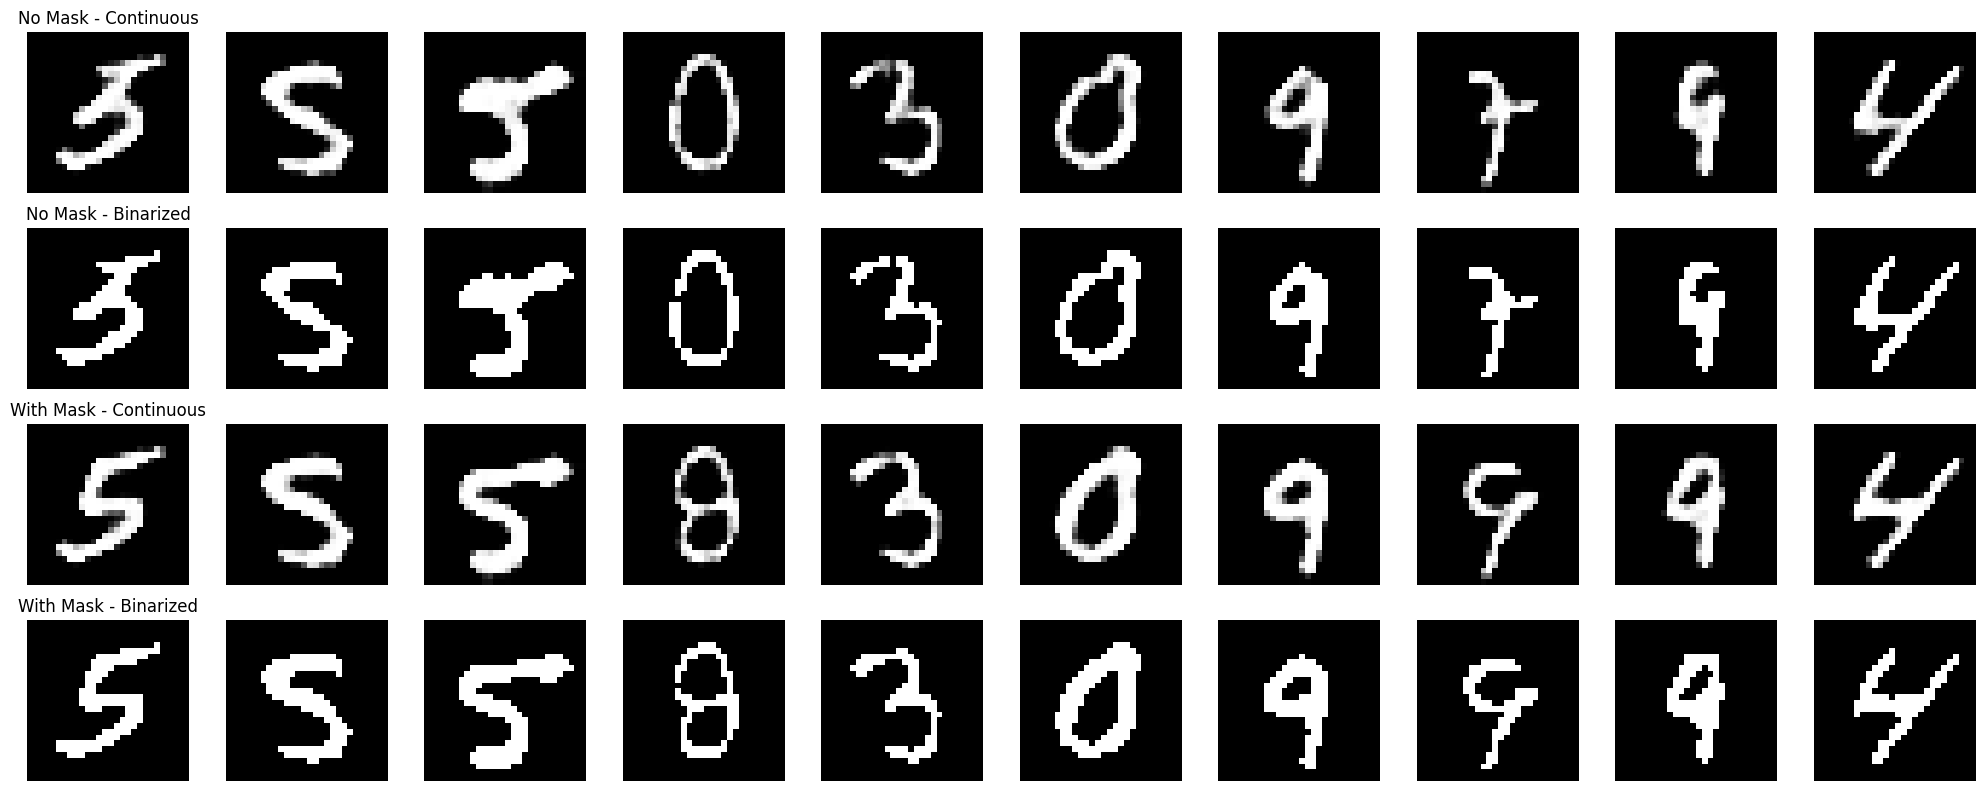

In [48]:
# 加载MNIST数据集
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=10, shuffle=True)

# 加载模型
unet = DeepUNet(in_channels=2, T=T).cuda()
vae = VAE(latent_channels=2).cuda()
unet.load_state_dict(torch.load('deep_unet_model_v6.pth'))
vae.load_state_dict(torch.load('vae_model_binarized_optimized.pth'))
unet.eval()
vae.eval()

# 生成对比图并计算IoU和Mean L2 Norm
num_images = 10
with torch.no_grad():
    # 从MNIST数据集中取10张图像
    data_iter = iter(dataloader)
    x_0, _ = next(data_iter)  # [10, 1, 28, 28]
    x_0 = x_0.cuda()
    
    # 通过VAE编码得到z_0
    mu, logvar = vae.encode(x_0)  # mu, logvar: [10, 2*7*7]
    mu = mu.view(-1, 2, 7, 7)  # 调整形状为[10, 2, 7, 7]
    logvar = logvar.view(-1, 2, 7, 7)
    z_0 = vae.reparameterize(mu, logvar)  # 采样得到z_0: [10, 2, 7, 7]
    print(f"Initial z_0: mean {z_0.mean().item():.4f}, std {z_0.std().item():.4f}")
    
    # 无mask情况（直接解码z_0）
    x_generated_no_mask = vae.decode(z_0)
    x_generated_binarized_no_mask = binarize_tensor(x_generated_no_mask, threshold=0.5)
    
    # 有mask情况（latent inpaint）
    z_0_with_mask = latent_inpaint(z_0, unet)
    x_generated_with_mask = vae.decode(z_0_with_mask)
    x_generated_binarized_with_mask = binarize_tensor(x_generated_with_mask, threshold=0.5)
    
    print(f"Final z_0 (No Mask): mean {z_0.mean().item():.4f}, std {z_0.std().item():.4f}")
    print(f"Final z_0 (With Mask): mean {z_0_with_mask.mean().item():.4f}, std {z_0_with_mask.std().item():.4f}")
    
    # 计算IoU
    iou_scores = []
    for i in range(num_images):
        intersection = (x_generated_binarized_no_mask[i] * x_generated_binarized_with_mask[i]).sum()
        union = (x_generated_binarized_no_mask[i] + x_generated_binarized_with_mask[i]).clamp(0, 1).sum()
        iou = intersection / union if union > 0 else 0.0
        iou_scores.append(iou.item())
        print(f"Image {i} IoU: {iou.item():.4f}")
    
    mean_iou = sum(iou_scores) / len(iou_scores)
    print(f"Mean IoU across {num_images} images: {mean_iou:.4f}")
    
    # 计算Mean L2 Norm（未二值化）
    l2_norms = []
    for i in range(num_images):
        l2_norm = torch.sqrt(torch.sum((x_generated_no_mask[i] - x_generated_with_mask[i]) ** 2))
        l2_norms.append(l2_norm.item())
        print(f"Image {i} L2 Norm: {l2_norm.item():.4f}")
    
    mean_l2_norm = sum(l2_norms) / len(l2_norms)
    print(f"Mean L2 Norm across {num_images} images: {mean_l2_norm:.4f}")
    
    # 可视化对比图
    num_display = num_images  # 显示所有10张
    fig, axes = plt.subplots(4, num_display, figsize=(num_display * 2, 8))
    
    for i in range(num_display):
        # 第一行：无mask的连续值图像
        axes[0, i].imshow(x_generated_no_mask[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('No Mask - Continuous')
        
        # 第二行：无mask的二值化图像
        axes[1, i].imshow(x_generated_binarized_no_mask[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('No Mask - Binarized')
        
        # 第三行：有mask的连续值图像
        axes[2, i].imshow(x_generated_with_mask[i].cpu().squeeze(), cmap='gray')
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('With Mask - Continuous')
        
        # 第四行：有mask的二值化图像
        axes[3, i].imshow(x_generated_binarized_with_mask[i].cpu().squeeze(), cmap='gray')
        axes[3, i].axis('off')
        if i == 0:
            axes[3, i].set_title('With Mask - Binarized')
    
    plt.tight_layout()
    plt.show()